In [ ]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm


import os
import pickle

import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

X_train = pd.read_csv('Data/Data20260110/X_train_Final_10.csv', header=None, delimiter=',').values
X_test = pd.read_csv('LocalDisease/X_MI_1_5.csv', header=None, delimiter=',').values

Y_train_pca = pd.read_csv('Data/Data20260110/Y_data_train_pca.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('LocalDisease/Y_data_MI_1_pca.csv', header=None, delimiter=',').values




train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_pca, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)



torch.set_default_dtype(torch.float32)

In [ ]:
Device = 'cuda'


output_file = 'LocalDisease/Result/MVGP_MI_1_result.csv'

if not os.path.exists(output_file):
    with open(output_file, 'w') as f:
        f.write('Iteration,test_preds,estimated_params\n')

checkpoint = torch.load('multitask_gp_checkpoint_LocalD_tmp.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_21, 
                                               num_latents=model_params['num_latents'], 
                                               num_inducing=model_params['num_inducing'], 
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_21.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

In [ ]:
row_idx = 0

In [ ]:
input_point = test_y_21[row_idx, :]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_21, k=100)
bounds = bound.get_bounds(local_train_x)

In [ ]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform_Optimized(
        Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, 
        row_idx, test_y_21, bounds, 
        num_sampling=1200, warmup_step=300, num_chains=1, device=Device
    )

In [ ]:
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

In [ ]:
posterior_samples = Tools.extract_vector_params_from_mcmc(
    posterior_samples_Uniform,
    key="params",
    param_names=[f"theta_{i}" for i in range(10)]  # 你也可以用真实参数名
)

In [ ]:
Tools.visualize_posterior_1d_params(
    posterior_samples,
    true_params_tensor=X_test[row_idx],
    # true_params_tensor=None,
    bins=15,
    acf_lags=40,
    clip_percentiles=(0.5, 99.5),
    xlim=None, 
)

In [ ]:
posterior_samples

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============ 1. 数据准备 ============
# 假设 samples_dict 就是你的采样结果
param_names = [f'theta_{i}' for i in range(10)]
# 转为 numpy，堆叠成 (N_samples, 10) 矩阵
samples = np.column_stack([posterior_samples[k].cpu().numpy() for k in param_names])

# ============ 2. 后验相关矩阵热力图 ============
corr = np.corrcoef(samples, rowvar=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f",
            xticklabels=param_names, yticklabels=param_names,
            cmap="RdBu_r", vmin=-1, vmax=1, center=0, ax=ax)
ax.set_title("Posterior Correlation Matrix")
plt.tight_layout()
# plt.savefig("correlation_matrix.png", dpi=150)
plt.show()

# ============ 3. 精度矩阵（条件独立结构） ============
cov = np.cov(samples, rowvar=False)
precision = np.linalg.inv(cov)
# 标准化为偏相关矩阵
D = np.diag(1.0 / np.sqrt(np.diag(precision)))
partial_corr = -D @ precision @ D
np.fill_diagonal(partial_corr, 1.0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(partial_corr, annot=True, fmt=".2f",
            xticklabels=param_names, yticklabels=param_names,
            cmap="RdBu_r", vmin=-1, vmax=1, center=0, ax=ax)
ax.set_title("Partial Correlation Matrix (Conditional Independence)")
plt.tight_layout()
# plt.savefig("partial_correlation.png", dpi=150)
plt.show()

# ============ 4. 成对散点图（重点关注高相关参数对） ============
# 找出相关性最强的前5对
import itertools
pairs = []
for i, j in itertools.combinations(range(10), 2):
    pairs.append((i, j, abs(corr[i, j])))
pairs.sort(key=lambda x: x[2], reverse=True)

fig, axes = plt.subplots(1, 5, figsize=(25, 4))
for idx, (i, j, r) in enumerate(pairs[:5]):
    axes[idx].scatter(samples[:, i], samples[:, j], alpha=0.1, s=1)
    axes[idx].set_xlabel(param_names[i])
    axes[idx].set_ylabel(param_names[j])
    axes[idx].set_title(f"r = {corr[i,j]:.3f}")
plt.suptitle("Top 5 Correlated Parameter Pairs")
plt.tight_layout()
# plt.savefig("top_pairs.png", dpi=150)
plt.show()

# ============ 5. PCA 分析 ============
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(samples)
explained = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(10), explained, label="Individual")
ax.plot(range(10), np.cumsum(explained), 'r-o', label="Cumulative")
ax.set_xticks(range(10))
ax.set_xticklabels([f"PC{i}" for i in range(10)])
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("PCA of Posterior Samples")
ax.legend()
plt.tight_layout()
# plt.savefig("pca.png", dpi=150)
plt.show()

# 主成分载荷
loadings = pca.components_  # (10, 10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(loadings[:5], annot=True, fmt=".2f",
            xticklabels=param_names, yticklabels=[f"PC{i}" for i in range(5)],
            cmap="RdBu_r", center=0, ax=ax)
ax.set_title("PCA Loadings (Top 5 Components)")
plt.tight_layout()
# plt.savefig("pca_loadings.png", dpi=150)
plt.show()

# ============ 6. Spearman 秩相关（捕获非线性） ============
spearman_corr, _ = stats.spearmanr(samples)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1,
            xticklabels=param_names, yticklabels=param_names, ax=axes[0])
axes[0].set_title("Pearson Correlation")
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1,
            xticklabels=param_names, yticklabels=param_names, ax=axes[1])
axes[1].set_title("Spearman Rank Correlation")
plt.tight_layout()
# plt.savefig("pearson_vs_spearman.png", dpi=150)
plt.show()

# ============ 7. 汇总报告 ============
print("="*60)
print("后验相关结构分析摘要")
print("="*60)
print(f"\n样本数: {samples.shape[0]}, 参数数: {samples.shape[1]}")
print(f"\n--- 强相关参数对 (|r| > 0.5) ---")
for i, j, r in pairs:
    if r > 0.5:
        print(f"  {param_names[i]} <-> {param_names[j]}: r = {corr[i,j]:+.3f}")

print(f"\n--- PCA 累计方差 ---")
for k in [1, 3, 5]:
    print(f"  前{k}个主成分解释方差: {np.cumsum(explained)[k-1]*100:.1f}%")

print(f"\n--- Pearson vs Spearman 差异大的参数对 (可能存在非线性) ---")
for i, j in itertools.combinations(range(10), 2):
    diff = abs(corr[i,j] - spearman_corr[i,j])
    if diff > 0.05:
        print(f"  {param_names[i]} <-> {param_names[j]}: "
              f"Pearson={corr[i,j]:+.3f}, Spearman={spearman_corr[i,j]:+.3f}, Δ={diff:.3f}")

# MCMC load

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
from typing import Optional, Sequence
import warnings

import pickle

# ── optional: if you keep samples as torch tensors ──────────────────────
try:
    import torch
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False

In [2]:

# ╔═══════════════════════════════════════════════════════════════════════╗
# ║  SECTION 1 — DATA CONVERSION (single case)                           ║
# ╚═══════════════════════════════════════════════════════════════════════╝

def posterior_dict_to_array(
    samples: dict,
    param_order: Optional[list[str]] = None,
) -> tuple[np.ndarray, list[str]]:
    """Convert {param_name: tensor/array (M,)} → (M, P) numpy array."""
    if param_order is None:
        # sort like param_0, param_1, ..., otherwise lexicographic
        param_order = sorted(
            samples.keys(),
            key=lambda k: int(k.split("_")[-1]) if k.split("_")[-1].isdigit() else k
        )

    cols = []
    for k in param_order:
        v = samples[k]
        if HAS_TORCH and isinstance(v, torch.Tensor):
            v = v.detach().cpu().numpy()
        cols.append(np.asarray(v, dtype=np.float64))

    X = np.column_stack(cols)  # (M, P)
    return X, param_order


# ╔═══════════════════════════════════════════════════════════════════════╗
# ║  SECTION 2 — CORRELATION (single case)                               ║
# ╚═══════════════════════════════════════════════════════════════════════╝

def corr_matrix(samples: np.ndarray, method: str = "pearson") -> np.ndarray:
    """Compute (P, P) correlation matrix from (M, P) posterior draws."""
    X = np.asarray(samples, dtype=np.float64)

    if method == "pearson":
        return np.corrcoef(X, rowvar=False)

    if method == "spearman":
        # rank transform per column (simple version; ties get arbitrary order)
        ranks = np.argsort(np.argsort(X, axis=0), axis=0).astype(np.float64)
        return np.corrcoef(ranks, rowvar=False)

    raise ValueError(f"Unknown method: {method}")


def partial_corr_matrix(samples: np.ndarray, ridge: float = 1e-8) -> np.ndarray:
    """Partial correlation via precision = inv(Cov + ridge*I)."""
    X = np.asarray(samples, dtype=np.float64)
    C = np.cov(X, rowvar=False)

    P = C.shape[0]
    # ridge for numerical stability (especially if M is not >> P)
    Prec = np.linalg.pinv(C + ridge * np.eye(P))

    D = np.sqrt(np.clip(np.diag(Prec), 1e-30, np.inf))
    Pcorr = -Prec / np.outer(D, D)
    np.fill_diagonal(Pcorr, 1.0)
    return Pcorr


def process_single_case(
    case_samples: dict,
    method: str = "pearson",
    param_order: Optional[list[str]] = None,
    compute_partial: bool = True,
    ridge: float = 1e-8,
) -> dict:
    """One case: return correlation (and optional partial correlation)."""
    X, names = posterior_dict_to_array(case_samples, param_order=param_order)
    R = corr_matrix(X, method=method)

    out = {"R": R, "param_names": names}
    if compute_partial:
        out["Pcorr"] = partial_corr_matrix(X, ridge=ridge)
    return out


# ╔═══════════════════════════════════════════════════════════════════════╗
# ║  SECTION 3 — PLOTTING (single case)                                  ║
# ╚═══════════════════════════════════════════════════════════════════════╝

CMAP_CORR = "RdBu_r"

def _draw_heatmap(
    ax, mat, labels, *,
    cmap=CMAP_CORR, vmin=-1, vmax=1,
    title="", annotate=False, fmt=".2f",
    block_edges=None,
):
    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax,
                   aspect="equal", interpolation="nearest")

    P = mat.shape[0]
    ax.set_xticks(range(P))
    ax.set_yticks(range(P))
    ax.set_xticklabels(labels, rotation=90, fontsize=7)
    ax.set_yticklabels(labels, fontsize=7)
    ax.set_title(title, fontsize=10, fontweight="bold", pad=8)

    if annotate and P <= 20:
        for i in range(P):
            for j in range(P):
                val = mat[i, j]
                ax.text(j, i, f"{val:{fmt}}",
                        ha="center", va="center", fontsize=5.5,
                        color="white" if abs(val) > 0.5 else "black")

    if block_edges is not None:
        cum = 0
        for g in block_edges[:-1]:
            cum += g
            ax.axhline(cum - 0.5, color="k", lw=0.8)
            ax.axvline(cum - 0.5, color="k", lw=0.8)

    return im


def plot_single_case_corr(
    R: np.ndarray,
    labels: list[str],
    title: str = "Posterior Correlation (single case)",
    annotate: bool = True,
    block_edges: Optional[list[int]] = None,
    save: Optional[str] = None,
    dpi: int = 200,
):
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 5.6), constrained_layout=True)
    im = _draw_heatmap(ax, R, labels, vmin=-1, vmax=1,
                      title=title, annotate=annotate, block_edges=block_edges)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("r", fontsize=9)
    if save:
        fig.savefig(save, dpi=dpi, bbox_inches="tight")
    return fig


def plot_single_case_corr_and_partial(
    R: np.ndarray,
    Pcorr: np.ndarray,
    labels: list[str],
    annotate: bool = True,
    block_edges: Optional[list[int]] = None,
    save: Optional[str] = None,
    dpi: int = 200,
):
    fig, axes = plt.subplots(1, 2, figsize=(11.5, 5.6), constrained_layout=True)
    im1 = _draw_heatmap(axes[0], R, labels, vmin=-1, vmax=1,
                       title="Correlation (Pearson/Spearman)", annotate=annotate,
                       block_edges=block_edges)
    im2 = _draw_heatmap(axes[1], Pcorr, labels, vmin=-1, vmax=1,
                       title="Partial correlation", annotate=annotate,
                       block_edges=block_edges)

    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.02, label="r")
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.02, label="partial r")

    if save:
        fig.savefig(save, dpi=dpi, bbox_inches="tight")
    return fig


# # ╔═══════════════════════════════════════════════════════════════════════╗
# # ║  SECTION 4 — DEMO (single case)                                      ║
# # ╚═══════════════════════════════════════════════════════════════════════╝

# def generate_demo_case(
#     n_params: int = 10,
#     n_draws: int = 2000,
#     rho: float = 0.5,
#     seed: int = 42,
# ) -> dict:
#     """Synthesise ONE case dict with neighbour correlation rho."""
#     rng = np.random.default_rng(seed)

#     C = np.eye(n_params)
#     for k in range(n_params - 1):
#         r = rho + rng.normal(0, 0.05)
#         r = np.clip(r, -0.95, 0.95)
#         C[k, k + 1] = r
#         C[k + 1, k] = r

#     # ensure PD
#     eigvals = np.linalg.eigvalsh(C)
#     if eigvals.min() < 1e-6:
#         C += (1e-6 - eigvals.min()) * np.eye(n_params)

#     draws = rng.multivariate_normal(np.ones(n_params), C, size=n_draws)
#     return {f"param_{i}": draws[:, i] for i in range(n_params)}


# ╔═══════════════════════════════════════════════════════════════════════╗
# ║  SECTION 5 — EXAMPLE USAGE                                           ║
# ╚═══════════════════════════════════════════════════════════════════════╝



In [17]:
with open("LocalDisease/Result/MVGP_MI_2_mcmc_result/result_21.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

In [5]:
with open("LocalDisease/Result/MVGP_MI_3_mcmc_result/result_2.pkl", "rb") as f:
    loaded_samples_chain2 = pickle.load(f)

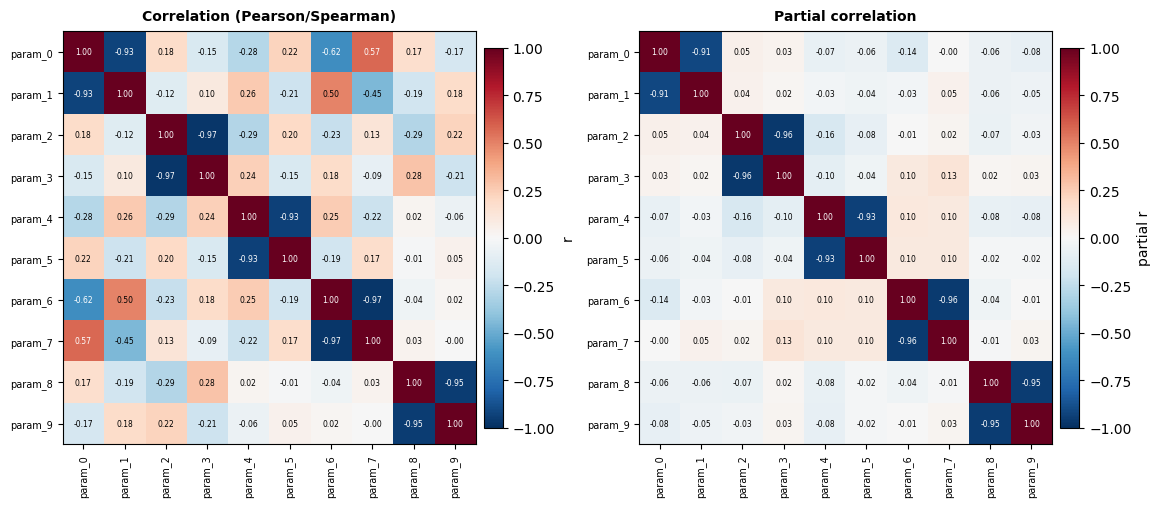

In [18]:
if __name__ == "__main__":
    case = loaded_samples_chain1

    res = process_single_case(case, method="pearson", compute_partial=True, ridge=1e-8)
    R = res["R"]
    Pc = res["Pcorr"]
    names = res["param_names"]

    plot_single_case_corr_and_partial(R, Pc, names, annotate=True)
    plt.show()

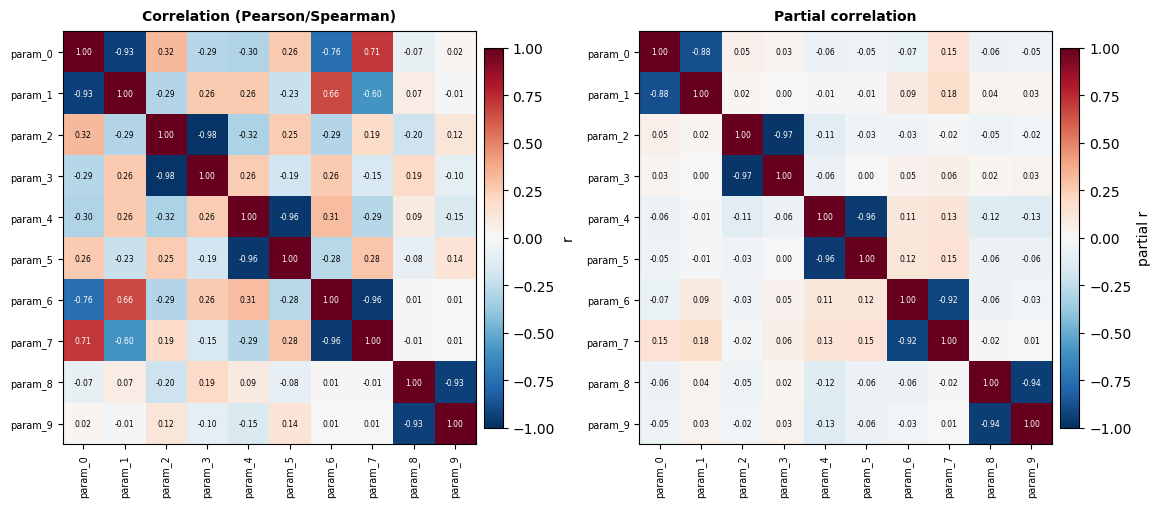

In [6]:
if __name__ == "__main__":
    case = loaded_samples_chain2

    res = process_single_case(case, method="pearson", compute_partial=True, ridge=1e-8)
    R = res["R"]
    Pc = res["Pcorr"]
    names = res["param_names"]

    plot_single_case_corr_and_partial(R, Pc, names, annotate=True)
    plt.show()

In [8]:
CMAP_DELTA  = "PiYG"

def plot_delta_two_cases(
    R_ref: np.ndarray,
    R_cmp: np.ndarray,
    labels: list[str],
    ref_name: str = "case1",
    cmp_name: str = "case2",
    block_edges: Optional[list[int]] = None,
    annotate: bool = True,
    save: Optional[str] = None,
    dpi: int = 200,
):
    delta = R_cmp - R_ref
    vlim = np.ceil(np.abs(delta).max() * 10) / 10  # round up to 0.1

    fig, ax = plt.subplots(1, 1, figsize=(6.2, 5.6), constrained_layout=True)
    im = _draw_heatmap(
        ax, delta, labels,
        cmap=CMAP_DELTA, vmin=-vlim, vmax=vlim,
        title=f"ΔR  ({cmp_name} - {ref_name})",
        annotate=annotate,
        block_edges=block_edges,
    )
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("Δr", fontsize=9)

    if save:
        fig.savefig(save, dpi=dpi, bbox_inches="tight")
    return fig

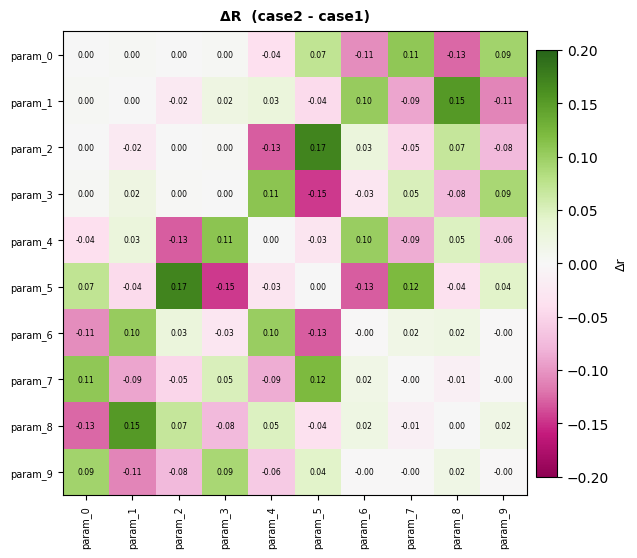

In [9]:
R1 = process_single_case(loaded_samples_chain1, method="pearson", compute_partial=False, ridge=1e-8)["R"]
R2 = process_single_case(loaded_samples_chain2, method="pearson", compute_partial=False, ridge=1e-8)["R"]

fig = plot_delta_two_cases(R1, R2, names, ref_name="case1", cmp_name="case2")
plt.show()

In [12]:
R1

array([[ 1.        , -0.93611576,  0.32159176, -0.28950289, -0.2614715 ,
         0.18815597, -0.65100127,  0.60146859,  0.05462392, -0.07628362],
       [-0.93611576,  1.        , -0.26975025,  0.23958207,  0.23744086,
        -0.18179093,  0.55691355, -0.50878977, -0.08140427,  0.09580848],
       [ 0.32159176, -0.26975025,  1.        , -0.97885913, -0.1867907 ,
         0.0794107 , -0.31973576,  0.23375257, -0.27210818,  0.19548317],
       [-0.28950289,  0.23958207, -0.97885913,  1.        ,  0.14750049,
        -0.04700486,  0.28691278, -0.20030484,  0.26396193, -0.19072387],
       [-0.2614715 ,  0.23744086, -0.1867907 ,  0.14750049,  1.        ,
        -0.93345011,  0.20571938, -0.20055262,  0.04204769, -0.08578223],
       [ 0.18815597, -0.18179093,  0.0794107 , -0.04700486, -0.93345011,
         1.        , -0.14690587,  0.15410526, -0.04329059,  0.0935266 ],
       [-0.65100127,  0.55691355, -0.31973576,  0.28691278,  0.20571938,
        -0.14690587,  1.        , -0.97208516

# End